In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
from SNARS import Snars
from time import sleep
import re
import pandas as pd
import json

## P8.1
Prepare a code which draw for given network plot of the relation $C(k)$ [20%]

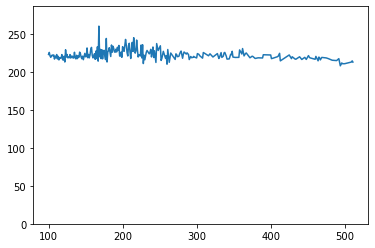

In [2]:
G = nx.generators.barabasi_albert_graph(1000, 100)
def plot_clustering_coeficient(G):
    def avg_degree(G: nx.Graph, k: int) -> float:
        dg =  dict(G.degree)
        k_nodes = [n for n, v in dg.items() if v==k] 
        averages = list(sum(dg[i] for i in G.neighbors(node))/k
                for node in k_nodes) ## list of Average degree of the nearest node for each node of degree k 
        return np.mean(averages)
    X = np.unique(list(dict(G.degree).values()))
    Y = list(map(lambda x: avg_degree(G, x), X))
    plt.plot(X, Y)
    plt.ylim(0, max(Y)*1.1)
plot_clustering_coeficient(G)

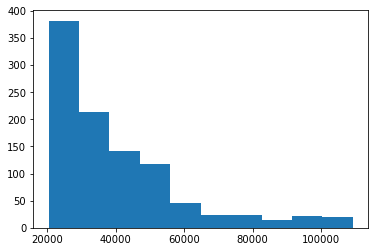

In [3]:
def plot_clustering_coeficient_hist(G):
    def avg_degree(G: nx.Graph, i: int) -> float:
        dg =  dict(G.degree)
        return sum(dg[n] for n in G.neighbors(i))## list of Average degree of the nearest node for each node of degree k 
    Y = list(map(lambda i: avg_degree(G, i), G.nodes))
    plt.hist(Y)
plot_clustering_coeficient_hist(G)

## P8.2
Find examples of hierarchical and non-hierarchical networks inavailable repositories, check by drawing graphs from the taskP8.1. [10%]

## P8.3
Load (perhaps a sub-) set of stops from the data provided byZTM Warszawa on the websitewww.ztm.waw.pl/pliki-do-pobrania/dane-rozkladowe/. Draw graphsbased on this set of vertices associated with the various typesof mass transport. [50%]

In [4]:
routes = json.load(open("routes_week.json", 'r'))
points = json.load(open("points.json", 'r'))
points = {k: (v['lon'], v['lat']) for k, v in points.items()}
edge_list=[]
for k,v in routes.items():
    for end in v.keys():
        edge_list+=[(k, end)]
G = nx.from_edgelist(edge_list)

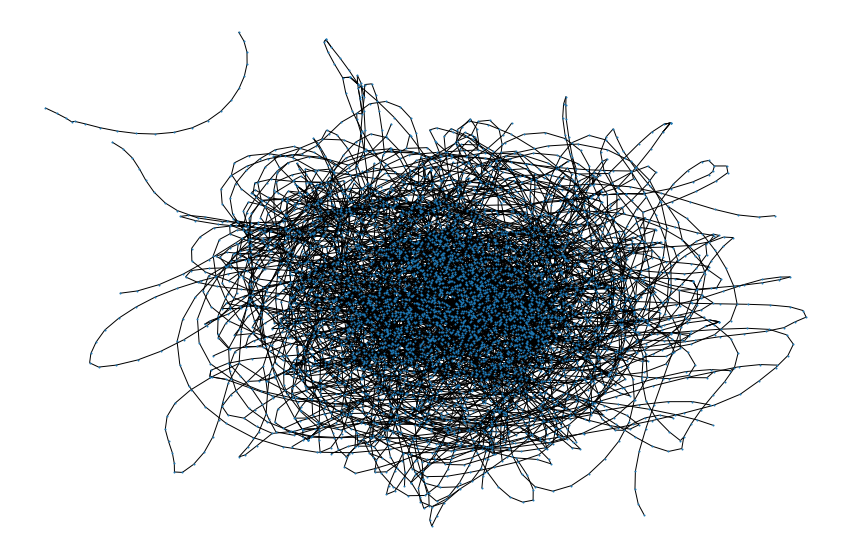

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw_spring(G, node_size =1, ax=ax )

## P8.4
Calculate the basic characteristics of each layer, and the wholenetwork. [20%]

In [6]:
def mle(degree_list):
    x_min = min(degree_list)
    return 1 + len(degree_list) / (np.log(x_min) + sum(np.log(degree_list)))

def summary(G : nx.graph) -> dict:
    degrees = list(dict(G.degree).values())
    return {
        'N' : len(G.nodes),
        'E' : len(G.edges),
        '<k>': np.mean(degrees),
        'alpha': mle(degrees),
        'avg clustering': nx.average_clustering(nx.subgraph(G, max(nx.connected_components(G), key=len)))
    }
pd.DataFrame([summary(G)])

,N,E,<k>,alpha,avg clustering
0,6648,8294,2.495187,2.160073,0.01706


## P8.5

Translate GPS coordinates to configuration of the vertices anddraw graph in proper, geographic, configuration. [30%]

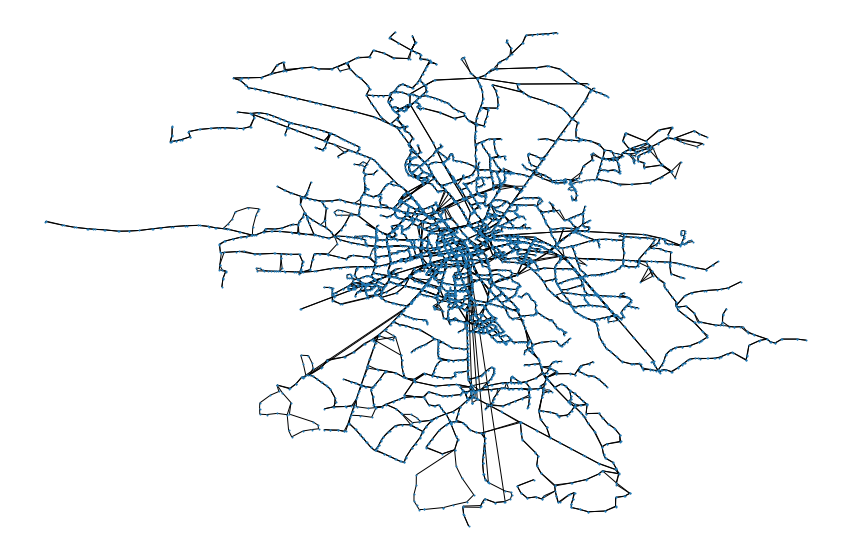

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(G, pos=points, node_size =1, ax=ax)

# P8.6
Taking into account the time table data, obtain the temporalnetwork from the graphs from the previous task. [20%]

In [8]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [9]:
stops_by_time = {"0": {'700202'}} #tu startujemy
points_time = json.load(open("points.json", 'r'))
def get_near_points(node):
    """For each point (node) returns a set of points within 400meters or 3 min by bus
    """
    result=set()
    lat, lon = points_time[node]['lat'], points_time[node]['lon']
    for node, position in points_time.items():
        if haversine(lon, lat, position['lon'], position['lat'])<=0.400:
            result.add(node)  
    for node, time_needed in points_time[node]["routes"].items():
        if time_needed<=3:
            result.add(node)
    return result 
        
N=30
for i in range(1, N):          
    stops_by_time[str(i)] = stops_by_time[str(i-1)].union(set([k for node in stops_by_time[str(i-1)] for k in get_near_points(node)]))
    print(i,':', stops_by_time[str(i)])
json.dump({k: list(v) for k, v in stops_by_time.items()}, open(f'stops_by_time_{N}.json', 'w'))

1 : {'700209', '700205', '503005', '700207', '700211', '700210', '700229', '700208', '503001', '700212', '700216', '700202', '790001', '790002', '700204', '700225', '503003', '700227', '700221', '791101', '700201', '700223', '503006', '790102', 'M2T001', '700214', '503004', '700230', '790101'}
2 : {'700211', '502003', '700202', '501901', '700204', '503003', '503101', '503002', '700214', '700230', '701203', '700205', '700210', '700208', '503001', '405206', '700212', '700216', '790001', '701308', '701305', '700227', 'M2K013', '701301', '708801', 'M1K010', '502004', '510101', '700207', '708803', '701306', '700225', '700221', '791101', '700102', '701303', '790102', '502002', '701309', '701310', '701304', '700209', '503005', '700101', '700229', '510002', '790002', '701307', 'M1M012', '405203', '502001', '700201', '700223', '503006', '405204', 'M2T001', '503004', '708810', '790101'}
3 : {'508802', '415201', '703401', '700211', '502003', '510102', '405201', '700202', '501901', '700204', '5023

7 : {'515402', '508802', '502804', '502003', '507301', '400113', '398402', '504102', '700614', '708205', '701203', 'M2T004', '790201', '511302', '414001', '509801', '700212', '490102', '704102', '590702', '507383', '500203', '709006', '412106', '510402', '700605', '706402', '700902', '701101', '703201', '708204', '708602', '700609', '702902', '400302', '703802', '500903', '704201', '415302', 'M2K010', '511201', '500201', '500310', '504008', '704601', '300106', '404201', '503705', '300105', '507001', '701108', '701501', '507102', '701102', '507306', '502601', '703703', '501902', '504002', '491101', '706301', '370602', '701403', '500905', '400106', '500304', '506901', '703402', '400201', '703804', '503101', '500908', '708510', '704004', 'M2K008', '706902', '506905', '701105', '704502', '402801', '702704', '400102', '709002', '701505', '415301', '709305', '709004', '703501', '510406', '506802', '511601', '703702', '405202', '709301', '701504', '707905', '708803', '400316', '415204', '4028

9 : {'515402', '508802', '504306', '502003', '400113', '701203', 'M2T004', '790201', '505901', '414001', '490102', '507383', '701703', '412106', '510402', '706402', '700902', '701101', '703201', '404306', '702902', '703802', 'M2K010', '511201', '500310', '504008', '704601', '705901', '503705', '704802', '590301', '410804', '300105', '701108', '515705', '701102', '502601', '703703', '501902', '504002', '491101', '701403', '501108', '500304', '400201', '703804', '704004', 'M2K008', '704502', '402801', '411702', '701505', '520501', '415301', '709305', '510406', '703702', '709301', '701504', '707905', '413701', '508702', '708803', '508603', '400316', '415204', '507002', '322804', '708001', '705801', '402804', '702601', '503601', '708902', '708507', '400506', '510404', '507302', '708810', '322803', '790101', '503604', '702702', '706701', '404305', '704106', '503803', '504089', '708802', '703502', '703706', '700205', '500806', '506902', '700210', '322801', '701607', '503001', '506904', '4117

11 : {'515402', '508802', '504306', '701805', '502003', '709105', '400113', '400601', '701203', 'M2T004', '790201', '415402', '505901', '414001', '323702', '490102', '328603', '500603', '702001', '507383', '701703', '412106', '510402', '706402', '700902', '701101', '703201', '404306', '415403', '511902', '702902', '703802', '702004', 'M2K010', '709104', '511201', '503404', '500310', '504008', '506001', '704601', '705901', '701803', '503705', '704802', '590301', '410804', '500101', '300105', '701108', '515705', '701102', '502601', '703703', '400606', '501902', '504002', '491101', '701403', '400605', '501108', '300306', '515902', '500304', '400201', '703804', '400604', '503407', '704004', 'M2K008', '704502', '402801', '411702', '701505', '520501', '415301', '709305', '510406', '703702', '709301', '701504', '707905', '413701', '508702', '508701', '708803', '508603', '400316', '415204', '507002', '322804', '708001', '705801', '402804', '702601', '503601', '708902', '708507', '400506', '510

12 : {'515402', '508802', '504306', '701805', '502003', '709105', '400113', '400601', '701203', 'M2T004', '790201', '708101', '415402', '503301', '505901', '414001', '323702', '490102', '328603', '500603', '702001', '507383', '701703', '412106', '510402', '706402', '700902', '701101', '703201', '404306', '415403', '511902', '702902', '323802', '703802', '702004', '705204', 'M2K010', '709104', '511201', '503404', '500310', '504008', '506001', '704601', '705901', '701803', '503705', '704802', '590301', '410804', '500101', '300105', '701108', '515705', '701102', '502601', '703703', '400606', '501902', '504002', '491101', '701403', '400605', '501108', '300306', '515902', '500304', '400701', '400201', '703804', '400604', '503407', '704004', 'M2K008', '704502', '402801', '411702', '701505', '312502', '520501', '415301', '709305', '510406', '703702', '709301', '701504', '707905', '413701', '508702', '508701', '708803', '508603', '506104', '400316', '415204', '501201', '507002', '322804', '708

13 : {'515402', '300604', '508802', '504306', '701805', '502003', '709105', '400113', '400601', '701203', 'M2T004', '790201', '708101', '415402', '503301', '505901', '414001', '323702', '323002', '490102', '328603', '500603', '702001', '507383', '701703', '412106', '510402', '706402', '700902', '701101', '703201', '404306', '415403', '511902', '702902', '323802', '703802', '702004', '705204', 'M2K010', '709104', '511201', '503404', '500310', '504008', '506001', '704601', '705901', '701803', '503705', '704802', '590301', '410804', '500101', '300105', '701108', '515705', '701102', '502601', '703703', '400606', '501902', '504002', '491101', '705504', '701403', '400605', '501108', '300306', '515902', '500304', '400701', '400201', '703804', '400604', '503407', '704004', 'M2K008', '704502', '402801', '411702', '400801', '701505', '312502', '520501', '415301', '709305', '510406', '703702', '709301', '701504', '707905', '413701', '508702', '508701', '708803', '508603', '506104', '400316', '415

14 : {'515402', '300604', '508802', '332602', '504306', '701805', '502003', '709105', '400113', '621502', '400601', '701203', 'M2T004', '790201', '708101', '415402', '503301', '505901', '414001', '323702', '323002', '490102', '328603', '500603', '702001', '507383', '701703', '412106', '608904', '510402', '706402', '700902', '701101', '703201', '404306', '415403', '511902', '702902', '323802', '305702', '703802', '702004', '705204', 'M2K010', '709104', '511201', '503404', '521102', '500310', '504008', '506001', '403202', '704601', '705901', '701803', '503705', '704802', '590301', '410804', '500101', '300105', '512302', '701108', '515705', '701102', '502601', '703703', '400606', '501902', '504002', '491101', '705504', '701403', '400605', '501108', '300306', '515902', '500304', '400701', '400201', '703804', '400604', '503407', '704004', 'M2K008', '704502', '402801', '411702', '400801', '701505', '312502', '520501', '415301', '709305', '510406', '703702', '709301', '701504', '707905', '413

KeyboardInterrupt: 

## P8.7
Make an animation of how traffic flows throughout the day.[30%]

<IPython.core.display.Javascript object>


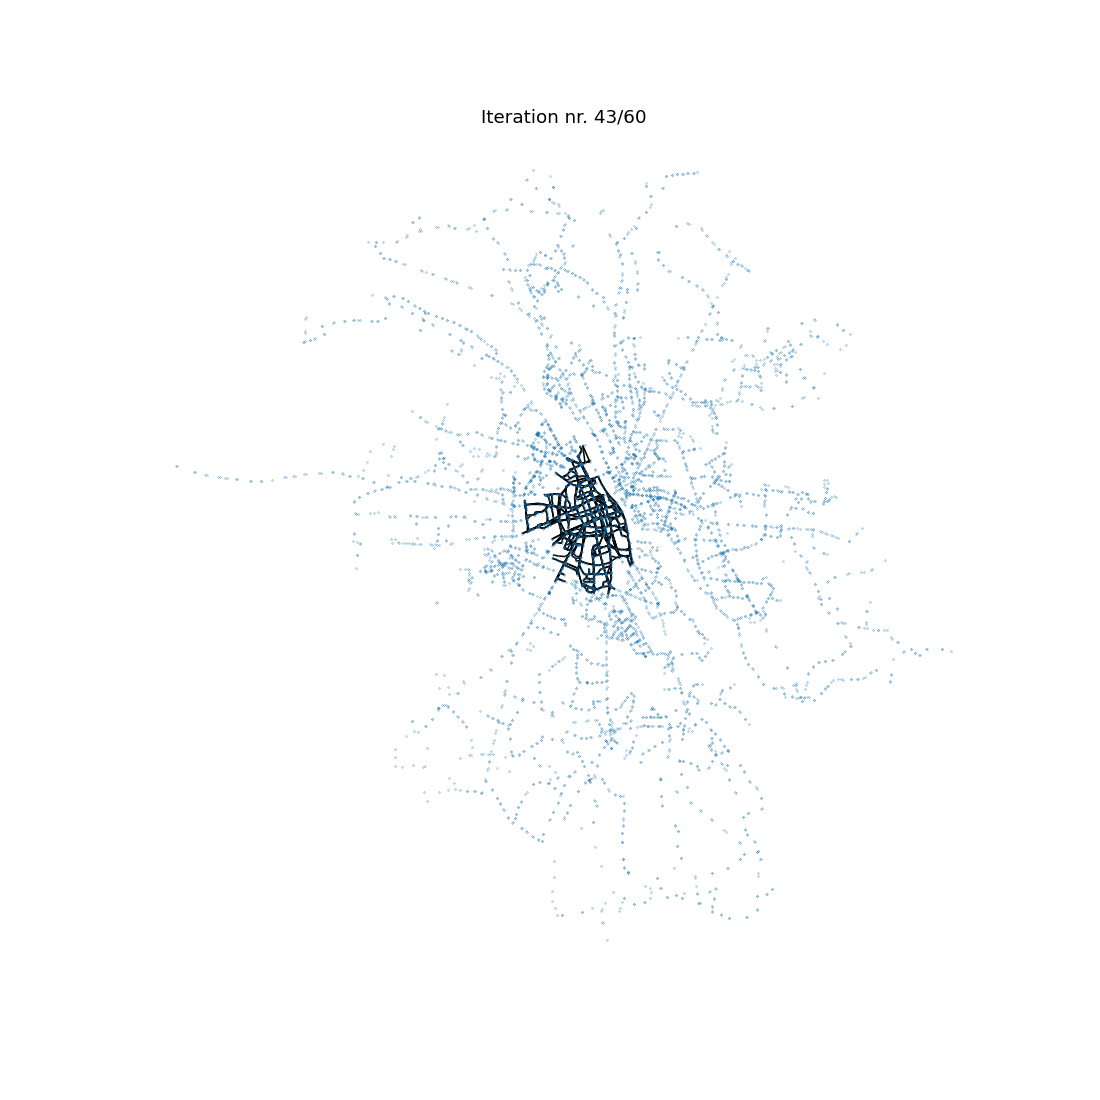

In [13]:
%matplotlib notebook
from copy import copy
from matplotlib.animation import FuncAnimation

stops_by_time = json.load(open(f"stops_by_time_{N}.json"))
fig, ax = plt.subplots(figsize=(10,10))   

def update(frame):
    try:
        ax.clear()
        G_plot = nx.Graph()
        G_plot.add_nodes_from(G.nodes)
        G_plot.add_edges_from( nx.subgraph(G, stops_by_time[str(int(frame))]).edges)
        nx.draw(G_plot, pos=points, node_size =0.05, ax=ax)
        ax.set_title(f"Iteration nr. {round(frame*2)}/{N*2}")
    except Exception as e:
        print(e)
    return ax

ani = FuncAnimation(fig, update, frames=np.linspace(0, N), interval=300)

## P8.8
Check how the selected network metrics depend on time. [20%]

In [ ]:
pd.DataFrame([summary(nx.subgraph(G, stops))for time, stops in stops_by_time.items()])    